In [1]:
%cd ~/programs/critic-llm/
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)

/home/nicholas/programs/critic-llm


In [2]:
from critic import load_llama_corrector
from critic.simple_corrector import UniformCorrector
corrector = load_llama_corrector(n_threads=1)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
llama_new_context_with_model: n_ctx_per_seq (256) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


In [ ]:
just_lm = load_llama_corrector()
just_lm.base = UniformCorrector()

llama_new_context_with_model: n_ctx_per_seq (256) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


In [3]:
df = pd.read_feather('precomputed/all_typos.feather')
print(df.shape)
df.head()

(35551, 12)


,kind,corrected,participant,weight,p,t,ist,i,j,context,wrong_char,right_char
0,omission,False,469,1.0,Can you help get this cleared up?,Can you help get th¬s cleared up?,Can you help get th␣s cleared up?,19,NaN,Can you help get this,s,i
1,substitute,True,469,1.0,Can you help get this cleared up?,Can you help get th¬s cleared up?,Can you help get th␣s cleared up?,20,19.0,Can you help get this c,␣,s
2,omission,False,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,25,NaN,Doctors gave him 10 years to,t,
3,insertion,True,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,25,NaN,Doctors gave him 10 years to,␣,t
4,insertion,True,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,26,NaN,Doctors gave him 10 years to,,t


In [4]:
last = df.groupby('p').last().reset_index()
prompts = last['p']
text = last['t']

def clean(series):
    return series.str.replace('␣', '').str.replace('¬', '')

last['p_clean'] = clean(prompts)
last['t_clean'] = clean(text)


clean = last[last['p_clean'].str.lower() != last['t_clean'].str.lower()][['p_clean', 't_clean']]

valid = clean[clean['p_clean'].str.count(' ') == clean['t_clean'].str.count(' ')]
valid.iloc[::100]

/tmp/ipykernel_424979/3213324013.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  last = df.groupby('p').last().reset_index()


,p_clean,t_clean
0,1.5 million visitors will flood Atlanta each d...,1.5 million visitors will flood Atlanta each d...
292,Are you getting all the information you need?,Are you gettig all the information you need?
550,Brady only has five catches this season.,Brady only has five catches this seaon.
799,Can you try this again?,Can ou tjry rhis again?
1036,Disney was great and I've been to eight baseba...,Disney was great and I;ve been to eight baseba...
1352,"Even if it were approved, Clinton could veto t...","Evn if it were approved, Clinton could veto th..."
1675,"He can be explosive, but he is also erratic.",he can be explosive ut he is also erratic
1974,He said he would resist all the pressure of ti...,He said he would resist all the presure of tim...
2263,"However, he is expected to play in this week's...","However, he is expected to play n this week's ..."
2545,I cannot figure out where these prices are com...,I cannot figure out where these prices re comi...


In [5]:
import pickle
from dataclasses import dataclass
from time import perf_counter
from tqdm import tqdm
from string import ascii_lowercase

from critic.corrector import Corrections
from critic.kbd_layout import QWERTY
from critic.simple_corrector import SimpleCorrector, UniformCorrector

@dataclass
class CorrectionResult:
    true: str
    typed: str
    corrs: Corrections
    context: str
    time: float


def evaluate(corrector, path):
    results = []
    data = valid[::20]
    for i, row in tqdm(data.iterrows(), total=data.shape[0]):
        corrector.clear_context()
        context = ''

        p_words = row['p_clean'].split(' ')
        t_words = row['t_clean'].split(' ')

        for true, typed in zip(p_words, t_words):
            if all(c.lower() in ascii_lowercase for c in true + typed):
                start = perf_counter()
                corrs = corrector.correct(typed)
                end = perf_counter()
                results.append(CorrectionResult(true, typed, corrs, context, end - start))
                corrector.push_word(true)
                context += true + ' '

    print(len(results))

    with open(f'results/{path}.pkl', 'wb') as f:
        pickle.dump(results, f)

    return results


opt_results = evaluate(corrector, 'optimized_probs_1cpu')
# kbd_results = evaluate(corrector.base, 'kbd_probs')
# lm_results = evaluate(just_lm, 'lm_probs')
# corrector.base.model = old_mod
# evaluate(corrector, 'old_probs')

# simple = SimpleCorrector()
# simple_results = evaluate(simple, 'simple_probs')

100%|██████████| 179/179 [09:30<00:00,  3.18s/it]

1229


In [6]:
from typing import Sequence


def grade(res: CorrectionResult):
    corrs = res.corrs.as_series().sort_values(ascending=False)
    if res.true in corrs.index:
        data = {
            'prob': corrs[res.true],
            'rank': list(corrs.index).index(res.true) + 1
        }
    else:
        data = {
            'prob': 0,
            'rank': np.nan
        }

    data['error'] = res.true != res.typed
    data['correct'] = res.true == corrs.index[0]
    data['time'] = res.time

    return data

def grade_all(results: Sequence[CorrectionResult]):
    return pd.DataFrame([grade(res) for res in results])

res_df = grade_all(opt_results)
res_df

,prob,rank,error,correct,time
0,0.811462,1.0,False,True,2.058240
1,0.998357,1.0,False,True,0.907788
2,0.996192,1.0,False,True,0.465724
3,0.999478,1.0,False,True,0.175573
4,0.995933,1.0,False,True,0.488492
...,...,...,...,...,...
1224,0.999681,1.0,False,True,0.283300
1225,0.999283,1.0,False,True,0.318740
1226,0.926308,1.0,False,True,0.342740
1227,0.999673,1.0,False,True,0.619771


In [43]:
ranks = res_df['rank']

((ranks > 5) & (ranks < 20)).mean()

np.float64(0.03336045565500407)

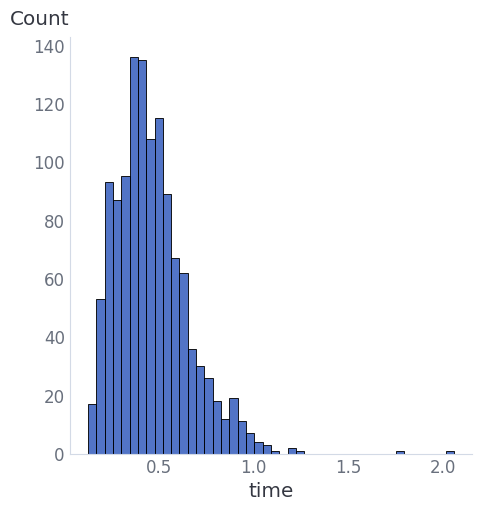

In [7]:
sns.displot(res_df, x='time')
rp.ylabel_top()

In [13]:

thread_df = grades.query('model == "LM + Keyboard"').copy().drop(columns=['model'])
thread_df['cores'] = 2
res_df['cores'] = 1

thread_df = pd.concat([thread_df, res_df])
thread_df

,i,prob,rank,error,correct,time,in_list,cores
0,0.0,0.811462,1.0,False,True,1.824280,True,2
1,1.0,0.998357,1.0,False,True,0.759493,True,2
2,2.0,0.996192,1.0,False,True,0.289479,True,2
3,3.0,0.999478,1.0,False,True,0.109042,True,2
4,4.0,0.995933,1.0,False,True,0.384725,True,2
...,...,...,...,...,...,...,...,...
1224,NaN,0.999681,1.0,False,True,0.283300,NaN,1
1225,NaN,0.999283,1.0,False,True,0.318740,NaN,1
1226,NaN,0.926308,1.0,False,True,0.342740,NaN,1
1227,NaN,0.999673,1.0,False,True,0.619771,NaN,1


In [32]:
thread_df.groupby('cores').agg({'time': lambda x: np.mean(x > 0.8)}) * 100

,time
cores,
1,5.858421
2,0.650936


In [29]:
1 - (0.3375 / 0.43760)

0.2287477148080438

Text(0.5, 0.98, 'Seconds Per Word')

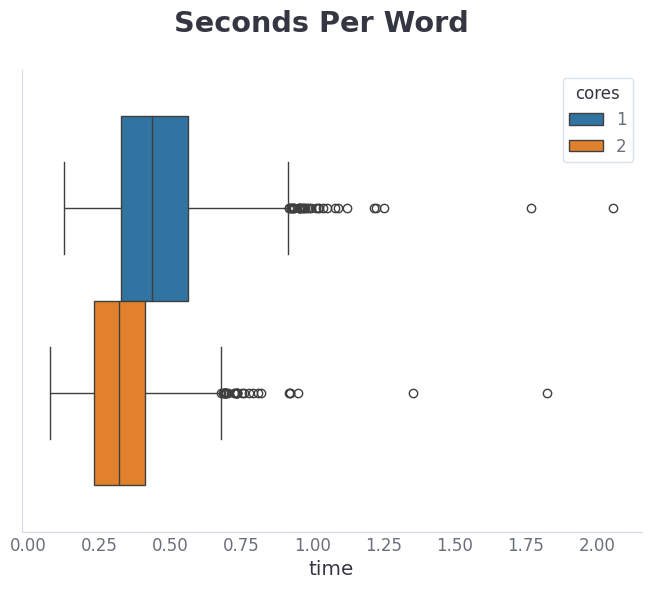

In [25]:
sns.boxplot(thread_df, x='time', hue='cores', palette='tab10')
plt.suptitle('Seconds Per Word')

In [49]:
critic = grades.query('model == "LM + Keyboard"')
pd.crosstab(critic['error'], critic['correct'])

correct,False,True
error,,
False,45,1033
True,63,88


correct,False,True
error,,
False,267,2967
True,241,212


,prob,rank,correct,time
model,,,,
Keyboard Only,0.521,1.636,0.896,0.137
LM + Keyboard,0.860,1.129,0.912,0.338
LM Only,0.707,1.626,0.779,0.252


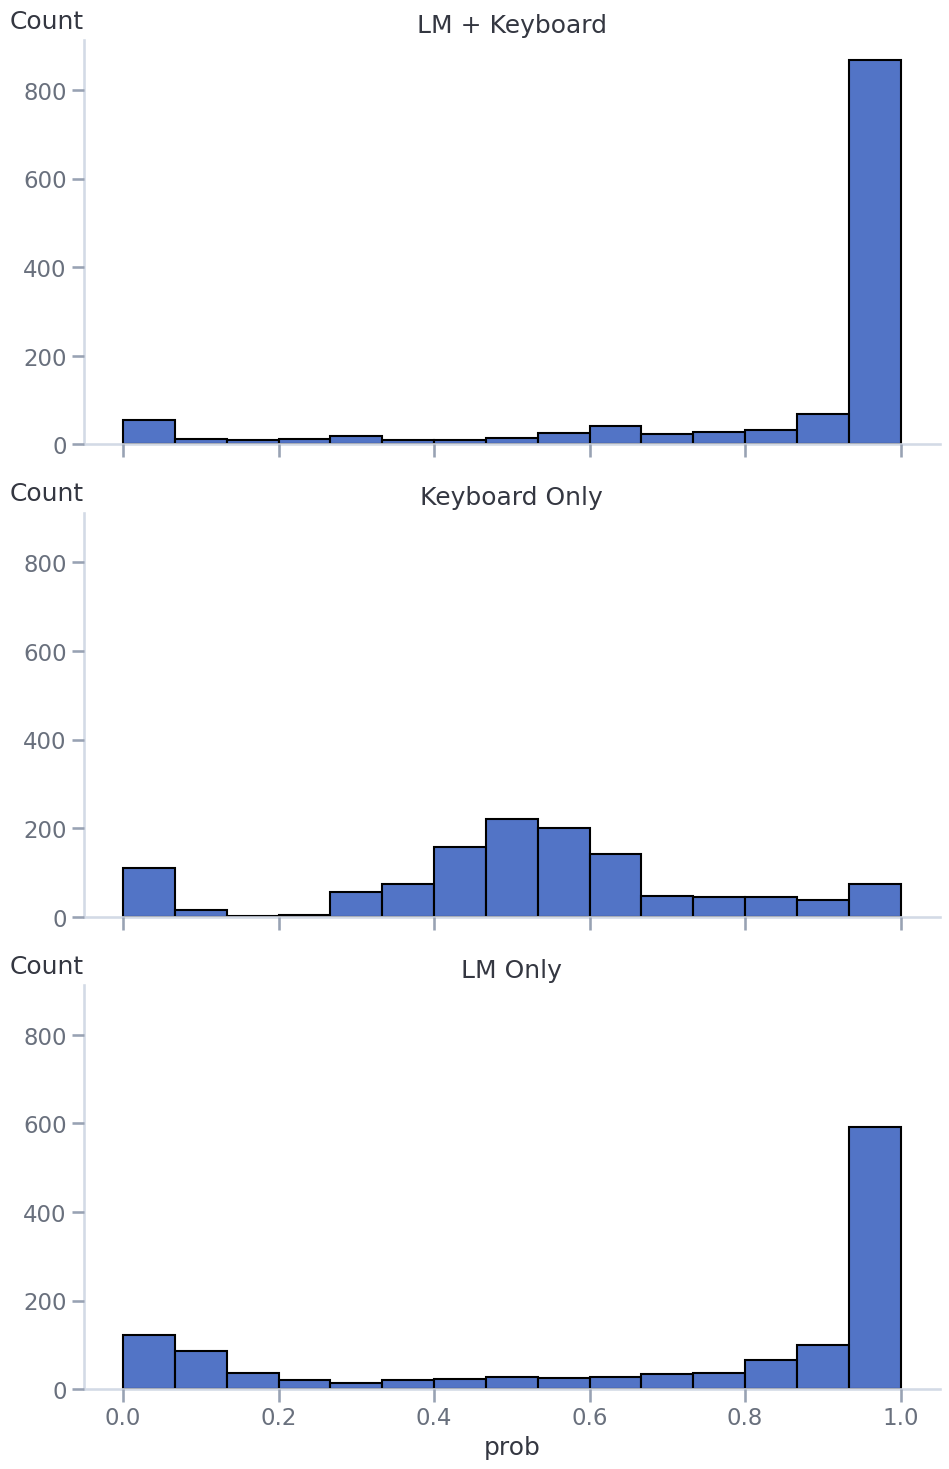

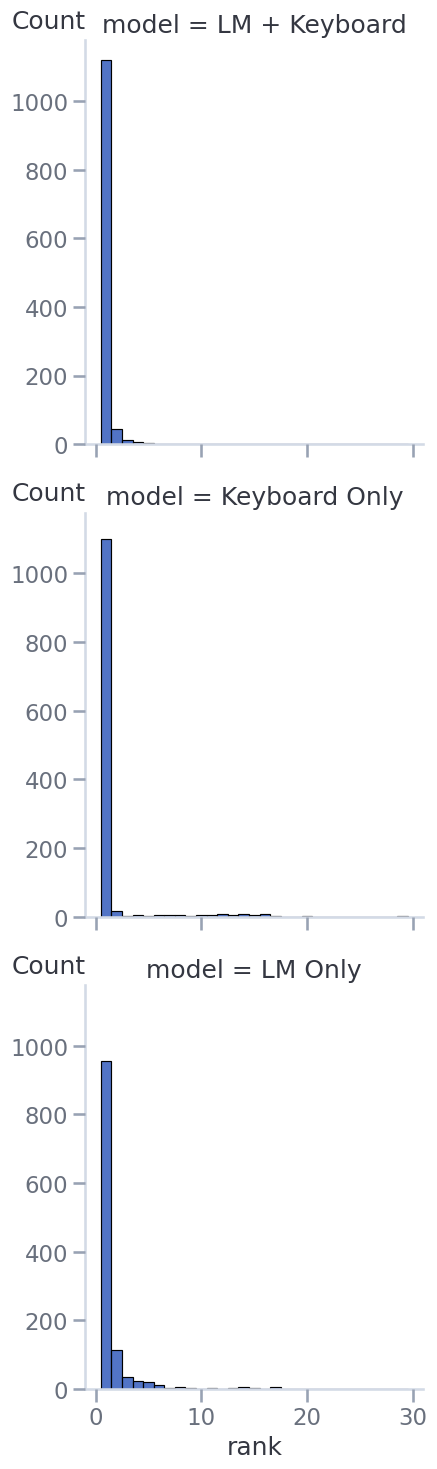

In [51]:
grade_dfs = []

for path, name in [    
    ('optimized_probs', 'LM + Keyboard'),
    ('kbd_probs', 'Keyboard Only'),
    ('lm_probs', 'LM Only')
]:
    with open(f'results/{path}.pkl', 'rb') as f:
        results = pickle.load(f)
        grades = grade_all(results)
        grades['model'] = name
        grade_dfs.append(grades)

grades = pd.concat(grade_dfs, axis=0).reset_index(names='i')
grades['in_list'] = ~pd.isna(grades['rank'])

display(pd.crosstab(grades['error'], grades['correct']))

display(grades.groupby('model').mean().round(3)[['prob', 'rank', 'correct', 'time']])
# display(grades.query('error').groupby('model').mean().round(2)[['prob', 'rank', 'correct']])

with sns.plotting_context('talk'):
    g = sns.displot(grades, x='prob', row='model', aspect=2)
    g.set_titles('{row_name}')
    for ax in g.axes.flatten():
        rp.ylabel_top(ax=ax)

    g = sns.displot(grades, x='rank', discrete=True, row='model')
    for ax in g.axes.flatten():
        rp.ylabel_top(ax=ax)

In [52]:
grades.query('in_list and error').groupby('model').mean().drop(columns=['i', 'in_list']).round(3)

,prob,rank,error,correct,time
model,,,,,
Keyboard Only,0.175,7.276,1.0,0.259,0.176
LM + Keyboard,0.722,1.750,1.0,0.759,0.390
LM Only,0.751,1.638,1.0,0.810,0.299


/home/nmiklaucic/miniconda3/envs/llm/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


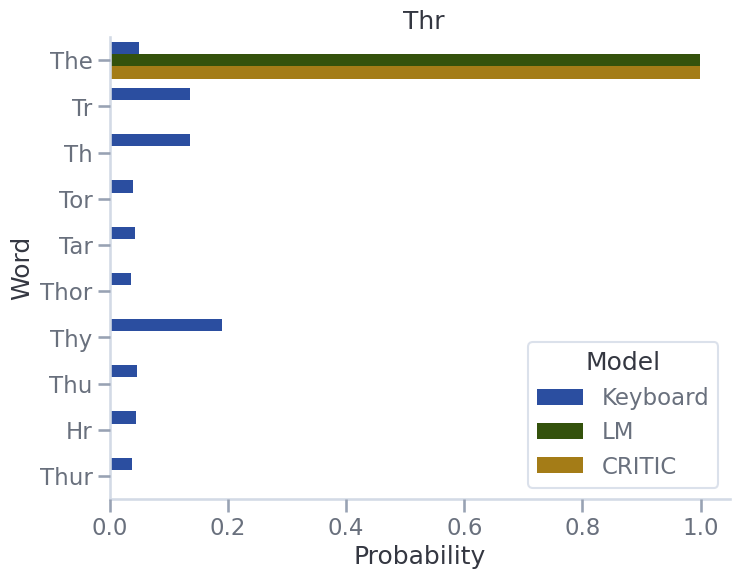

In [8]:
from copy import deepcopy


corrector = load_combo_corrector()


kbd_corrector = corrector.base
lm_corrector = load_combo_corrector()
lm_corrector.base = UniformCorrector()


context = ''
word = 'Thr'
# context = 'The coverage about me in the paper'
# word = 'gas'


corrector.push_words(context)
lm_corrector.push_words(context)

corrs = corrector.correct(word).as_series()
kbd_corrs = kbd_corrector.correct(word).as_series()
lm_corrs = lm_corrector.correct(word).as_series()


df = pd.DataFrame({'Keyboard': kbd_corrs, 'LM': lm_corrs, 'CRITIC': corrs}).reset_index(names='Word').sort_values('CRITIC', ascending=False).iloc[:10].melt(var_name='Model', value_name='Probability', id_vars=['Word'])

with sns.plotting_context('talk'):
    sns.barplot(df, x='Probability', y='Word', orient='h', hue='Model')
    plt.gca().set_title(f'{context} {word}')